In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Union, Callable, Tuple, Any
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Background / Motivation

Building the model that can effectively decide whether to give a loan or not can help bank to speed up the underwriting process. As the result from [[1]](), with useful information is provided, the model can achieve high performance. However, some information such as income is not accessible at first, and bank normally asks for the proof of income which takes time during the process. As banks, they want to know this before customers provide it to them in order to improve the underwriting process.


In practice, building the sophisticated income model is challenging due to lack of usable features, and so on. Alternatively, managaing/mitigating the uncertainty of the model at least helps bank to tradeoff between risk and profit.

In [2]:
df = pd.read_csv("../data/loan-train.csv")
df.head()
df.shape

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


(614, 13)

In [3]:
df["Loan_Status"] = (df["Loan_Status"] == "Y").astype(int)

## Feature engineering

**Total income**

Applicant income and Coapplicant income can determine the loan amount that customer can take.

In [4]:
df["TotalIncome"] = df["ApplicantIncome"] + df["CoapplicantIncome"]

**Income Bin**


In [5]:
df["TotalIncomeBin"] = pd.cut(
    df["TotalIncome"], 
    bins=[-np.inf, 3000, 5000, 9000, 17000, np.inf],
    labels=["<= 3000", "(3000, 5000]", "(5000, 9000]", "(9000, 17000]", "> 17000"]
).astype(str)

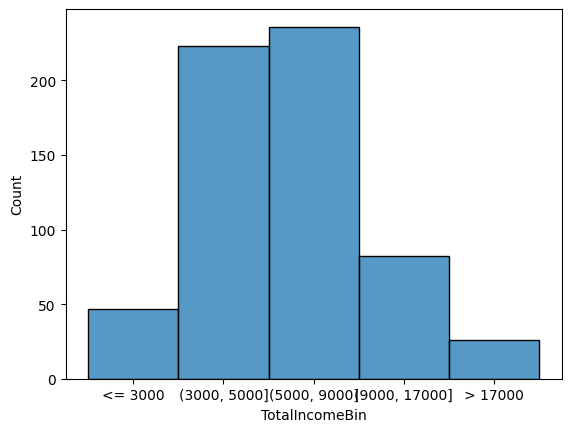

In [6]:
_ = sns.histplot(df["TotalIncomeBin"])

## Baseline loan model

Let's build the baseline for loan approval model.

In [6]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import PowerTransformer, OneHotEncoder

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

In [7]:
def safe_df(df: Any, cols: List[str] = None) -> pd.DataFrame:
    if isinstance(df, scipy.sparse._csr.csr_matrix):
        df = df.toarray()
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df, columns=cols)
    return df.reset_index(drop=True)


def encode_categorical_features(df: pd.DataFrame, feature_cols: List[str], target_col: str) -> Tuple[pd.DataFrame, ...]:
    if not feature_cols:
        return None, None
    df_encoded = df.copy()
    encoder = TargetEncoder()
    df_encoded = encoder.fit_transform(df_encoded[feature_cols], df_encoded[target_col])
    return safe_df(df_encoded, feature_cols), encoder

## One-hot
# def encode_categorical_features(df: pd.DataFrame, feature_cols: List[str], target_col: str = None) -> Tuple[pd.DataFrame, ...]:
#     if not feature_cols:
#         return None, None
#     df_encoded = df.copy()
#     encoder = OneHotEncoder()
#     df_encoded = encoder.fit_transform(df_encoded[feature_cols])
#     return safe_df(df_encoded), encoder


def encode_numerical_features(df: pd.DataFrame, feature_cols: List[str]) -> Tuple[pd.DataFrame, ...]:
    if not feature_cols:
        return None, None
    df_encoded = df.copy()
    encoder = PowerTransformer()
    df_encoded = encoder.fit_transform(df_encoded[feature_cols])
    return safe_df(df_encoded, feature_cols), encoder


def apply_encoder(df: pd.DataFrame, enc: Union[TargetEncoder, PowerTransformer], feature_cols: List[str]) -> pd.DataFrame:
    if not feature_cols:
        return None
    df_encoded = df.copy()
    df_encoded = enc.transform(df_encoded[feature_cols])
    return safe_df(df_encoded, cols=feature_cols if df_encoded.shape[1] == len(feature_cols) else None)

In [8]:
def rollout_result(
    model_fn: Callable, 
    df: pd.DataFrame,
    cat_features: List[str],
    num_features: List[str],
    target: str,
    metric_fn: Callable = accuracy_score,
    n_splits: int = 5,
    seed: int = 123
) -> Tuple[float, ...]:
    
    df_copy = df.copy()
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scores = []
    models = []

    for train_idx, test_idx in kf.split(df_copy, df_copy[target]):
        train_df, test_df = df_copy.iloc[train_idx].reset_index(drop=True), df_copy.iloc[test_idx].reset_index(drop=True)

        # encode training set
        train_encoded_cat, cat_encoder = encode_categorical_features(train_df, cat_features, target)
        train_encoded_num, num_encoder = encode_numerical_features(train_df, num_features)
        train_encoded = pd.concat([train_encoded_cat, train_encoded_num, train_df[[target]]], axis=1)

        # train the model
        model = model_fn()
        _ = model.fit(train_encoded.drop(target, axis=1), train_encoded[target])

        # encode testing set
        test_encoded_cat = apply_encoder(test_df, cat_encoder, cat_features)
        test_encoded_num = apply_encoder(test_df, num_encoder, num_features)
        test_encoded = pd.concat([test_encoded_cat, test_encoded_num, test_df[[target]]], axis=1)
        
        # evaluate
        pred = model.predict(test_encoded.drop(target, axis=1))
        y_true = test_encoded[[target]]
        
        scores.append(metric_fn(y_true, pred))
        models.append(model)

    best_idx = np.argmax(scores)
        
    return np.mean(scores), models[best_idx]

In [9]:
cat_features = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area", "Credit_History"]
num_features = ["ApplicantIncome", "TotalIncome", "LoanAmount", "Loan_Amount_Term"]
# num_features = ["LoanAmount", "Loan_Amount_Term"]
target = "Loan_Status"

df_copy = df.dropna().copy()

In [10]:
mean_scores, best_model = rollout_result(
    model_fn=lambda: CatBoostClassifier(iterations=1e3, depth=5, verbose=0),
    df=df_copy,
    cat_features=cat_features,
    num_features=num_features,
    target=target
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See 

In [11]:
mean_scores

0.8104166666666668

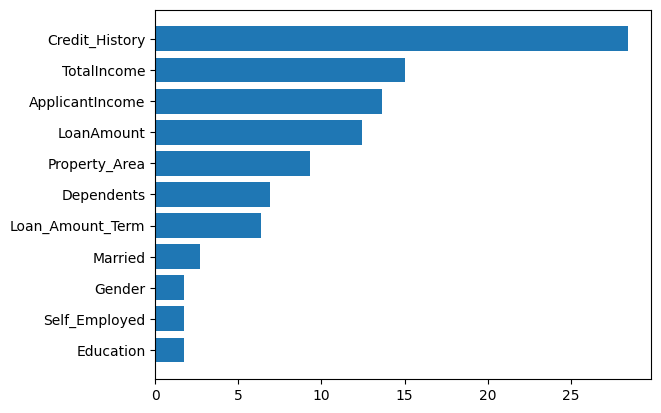

In [12]:
idx = np.argsort(best_model.feature_importances_)
_ = plt.barh(np.array(best_model.feature_names_)[idx], np.array(best_model.feature_importances_)[idx])

As the result, **ApplicantIncome** is in the top 3 important features. Let's see if we drop all income-related features out.

In [13]:
cat_features = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area", "Credit_History"]
num_features = ["Loan_Amount_Term"]
target = "Loan_Status"

df_copy = df.dropna().copy()

In [14]:
mean_scores, best_model = rollout_result(
    model_fn=lambda: CatBoostClassifier(iterations=1e3, depth=5, verbose=0),
    df=df_copy,
    cat_features=cat_features,
    num_features=num_features,
    target=target
)

/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/nutorbit/Library/Caches/pypoetry/virtualenvs/uncertainty-modeling-6RgNMiVj-py3.8/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See 

In [15]:
mean_scores

0.8

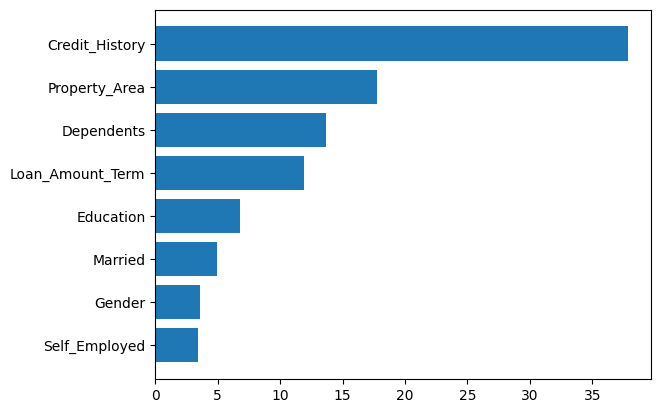

In [16]:
idx = np.argsort(best_model.feature_importances_)
_ = plt.barh(np.array(best_model.feature_names_)[idx], np.array(best_model.feature_importances_)[idx])

## Proxy Income



In [18]:
mean_scores, best_model = rollout_result(
    model_fn=lambda: CatBoostClassifier(iterations=1e3, depth=5, verbose=0),
    df=df_copy,
    cat_features=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"],
    num_features=[],
    target="TotalIncomeBin"
)

In [19]:
encoded, encoder = encode_categorical_features(df_copy, ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"], None)

In [20]:
print(
    classification_report(
        df_copy["TotalIncomeBin"],
        best_model.predict(encoded),
        labels=["<= 3000", "(3000, 5000]", "(5000, 9000]", "(9000, 17000]", "> 17000"]
    )
)

               precision    recall  f1-score   support

      <= 3000       0.57      0.11      0.18        38
 (3000, 5000]       0.55      0.58      0.57       173
 (5000, 9000]       0.52      0.73      0.61       180
(9000, 17000]       0.52      0.19      0.27        70
      > 17000       0.55      0.32      0.40        19

     accuracy                           0.53       480
    macro avg       0.54      0.38      0.41       480
 weighted avg       0.54      0.53      0.50       480



In [21]:
pd.DataFrame(
    confusion_matrix(
        df_copy["TotalIncomeBin"],
        best_model.predict(encoded),
        labels=["<= 3000", "(3000, 5000]", "(5000, 9000]", "(9000, 17000]", "> 17000"]
    ),
    index=["<= 3000", "(3000, 5000]", "(5000, 9000]", "(9000, 17000]", "> 17000"],
    columns=["<= 3000", "(3000, 5000]", "(5000, 9000]", "(9000, 17000]", "> 17000"]
)

,<= 3000,"(3000, 5000]","(5000, 9000]","(9000, 17000]",> 17000
<= 3000,4,17,16,1,0
"(3000, 5000]",2,101,64,6,0
"(5000, 9000]",1,40,132,4,3
"(9000, 17000]",0,18,37,13,2
> 17000,0,7,5,1,6


### Conformal prediction

Conformal prediction is a way to generate prediction sets for any model for free without modification needed. This method can construct the prediction set that satisfied the following

<!-- Equation -->
$$
1 - \alpha \le \mathbb{P}(Y_{test} \in C(X_{test})) \le 1 - \alpha + \frac{1}{n+1}
$$

where,

$\alpha$ is the error rate

$C(X_{test})$ is the prediction set

There are 3 steps to perform this method:

* Get the score $s$ (Larger scores encode worse agreement between x and y)
* Find the quantile of the score $\hat{q}$
* Form the prediction set $C(X_{test}) = \{y: s(X_{test}, y) \le \hat{q}\}$

**Split the data into 3 sets (train, calibrate, test)**

In [22]:
from imblearn.over_sampling import SMOTE

In [23]:
df_copy["TotalIncomeBin"].value_counts()

(5000, 9000]     180
(3000, 5000]     173
(9000, 17000]     70
<= 3000           38
> 17000           19
Name: TotalIncomeBin, dtype: int64

In [24]:
df_encoded, encoder = encode_categorical_features(
    df=df_copy, 
    feature_cols=["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"], 
    target_col=None
)

df_encoded["target"] = df_copy["TotalIncomeBin"].reset_index(drop=True)

# X, y = SMOTE().fit_resample(df_encoded.drop("target", axis=1), df_encoded["target"])

In [25]:
# df_encoded = X.copy()
# df_encoded["target"] = y

In [26]:
train, test = train_test_split(df_encoded, test_size=0.2, random_state=123)  # 80, 20
train, calibrate = train_test_split(train, test_size=0.3, random_state=123)

In [27]:
df_copy.shape, train.shape, calibrate.shape, test.shape

((480, 15), (268, 16), (116, 16), (96, 16))

**Training the model**

In [29]:
model = CatBoostClassifier(verbose=0)

model.fit(train.drop("target", axis=1), train["target"])

In [30]:
calibrate_label_index = calibrate["target"].map(lambda x: list(model.classes_).index(x))

**Conformal prediction**

In [32]:
alpha = 0.05
n = calibrate.shape[0]

scores = 1 - model.predict_proba(calibrate.drop("target", axis=1))[np.arange(n), calibrate_label_index]
q_level = np.ceil((n+1) * (1-alpha)) / n
qhat = np.quantile(scores, q_level, method="higher")

In [33]:
prob_pred = model.predict_proba(test.drop("target", axis=1))

<AxesSubplot: ylabel='Count'>

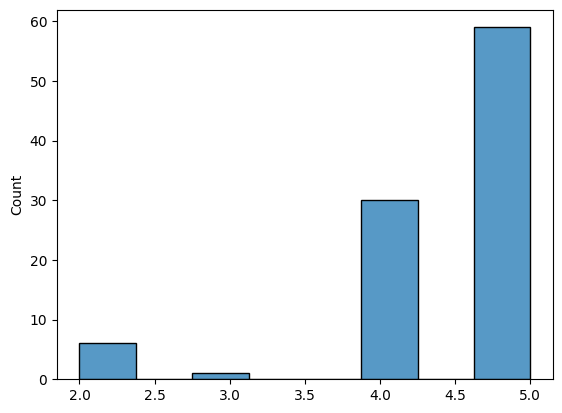

In [34]:
sns.histplot(list(map(lambda x: len(model.classes_[x]), prob_pred >= (1-qhat))))

In [36]:
for i, x in enumerate(list(map(lambda x: model.classes_[x], prob_pred >= (1-qhat)))):
    print(x, test.iloc[i, -1], sep="|")

['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000' '> 17000']|(5000, 9000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000' '> 17000']|(3000, 5000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000' '> 17000']|(3000, 5000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000' '> 17000']|(3000, 5000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000' '> 17000']|(5000, 9000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000' '> 17000']|(3000, 5000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000']|<= 3000
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000' '> 17000']|(3000, 5000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000']|(5000, 9000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000']|(5000, 9000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000']|(5000, 9000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000']|(3000, 5000]
['(3000, 5000]' '(5000, 9000]' '(9000, 17000]' '<= 3000' '> 17000']|(5000, 9000]
['

# References

1. [Loan Prediction w/ Various ML Models](https://www.kaggle.com/code/caesarmario/loan-prediction-w-various-ml-models/notebook)
2. [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511)